# Clipping Data


```{admonition} Summary
:class: hint


```

Clipping is a process used to extract specific parts of data based on a predefined dataset that represents the area of interest. The `geopandas` and `matplotlib` packages are used for this process.

In [18]:
import geopandas as gp
import matplotlib.pyplot as plt
from pathlib import Path

INPUT = Path.cwd().parents[0] / "00_data"
OUTPUT = Path.cwd().parents[0] / "out"
OUTPUT.mkdir(exist_ok=True)

gdb_path = INPUT / "Biotopwerte_Dresden_2018.gdb"

## Clipping Based on Zone (Dataset)

The areas of interest in this chapter are districts in Dresden. 

`````{admonition} Dresden Portal!
:class: attention, dropdown
The districts are extracted from the [Portal of Dresden](https://opendata.dresden.de/informationsportal/?open=1&result=493101D03C794E9C99CD8B2BAC194FEC#app/mainpage////).
`````

For retrieving the data, from the Geojson section of the portal, based on the interested format, the URL is chosen.

In [19]:
geojson_url = "https://kommisdd.dresden.de/net4/public/ogcapi/collections/L137/items"

Then the `requests` library is imported and a request is sent to the portal to extract the data.

In [20]:
import requests

response = requests.get(geojson_url)

Then if the request is successful (code 200), it will load and plot the data.

   id                   bez  \
0  44        Dresdner Heide   
1  42  Bühlau/Weißer Hirsch   
2  13       Innere Neustadt   
3  15           Albertstadt   
4  24               Trachau   

                                            bez_lang  flaeche_km2   sst  \
0                                     Dresdner Heide      48.3382  None   
1  Bühlau/Weißer Hirsch mit Rochwitz und Loschwit...       6.7596  None   
2                 Innere Neustadt mit Antonstadt-Süd       1.7903  None   
3                                        Albertstadt       7.4935  None   
4                                            Trachau       3.5192  None   

  sst_klar historie                 aend  \
0     None      akt  01.08.2024 00:00:00   
1     None      akt  01.08.2024 00:00:00   
2     None      akt  01.08.2024 00:00:00   
3     None      akt  01.08.2024 00:00:00   
4     None      akt  01.08.2024 00:00:00   

                                            geometry  
0  POLYGON ((13.87262 51.12741, 13.87258 5

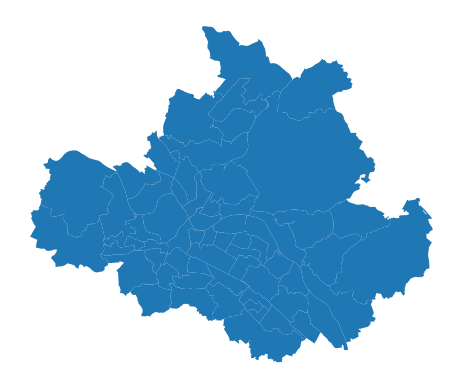

In [21]:
if response.status_code == 200:
    gdf = gp.read_file(geojson_url)
    print(gdf.head())
    ax=gdf.plot()
    ax.set_axis_off()
else:
    print("Error:", response.text)

`````{admonition} Selecting the area of interest!
:class: danger, dropdown
To select the area of interest, the methods mentioned in the [Selecting and Filtering Chapter](https://stag.training.fdz.ioer.info/notebooks/303_selecting_and_filtering.html#selecting-and-filtering-data) could be used, but also it is possible to add the labels to maps and select based on labels.
`````

To add the labels, first, the position of the labels should be defined.

The centroid of the polygons would be the position of the labels and is generated using the `geometry.centroid` method and stored in a new column.

In [ ]:
gdf["centroid"] = gdf.geometry.centroid 

For adding the labels the `text` function is used.

The coordinates of the centroid are the position of the labels and the label text is defined with `str`.
In the following example, the IDs of the districts are used.

`````{admonition} Labels in the map!
:class: note, dropdown
To customize the labels more, check [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html).
`````

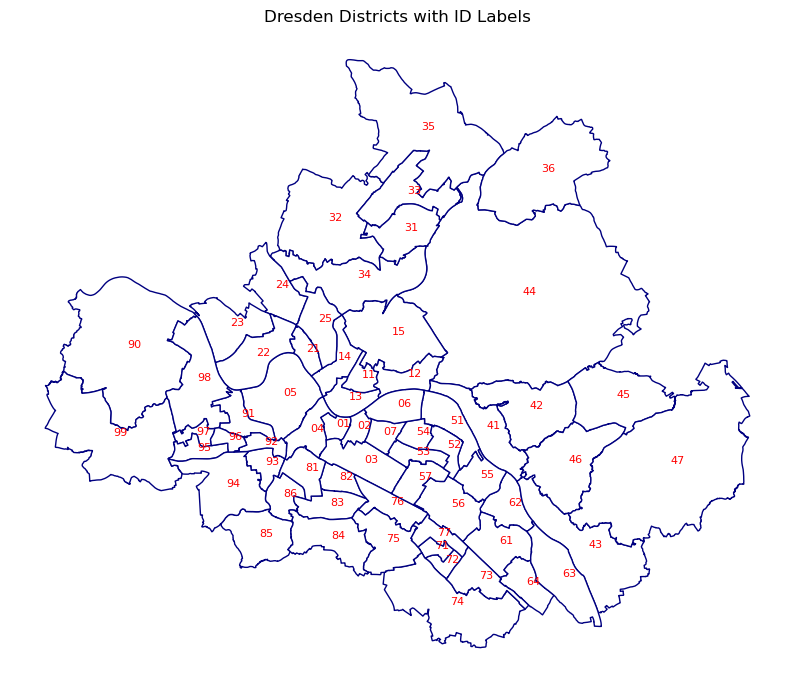

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='white', edgecolor='navy')
ax.set_axis_off()

for idx, row in gdf.iterrows():
    plt.text(row.centroid.x, row.centroid.y, str(row['id']),
             fontsize=8, 
             color='red')

plt.title("Dresden Districts with ID Labels")
plt.show()


Now using the labels the interested area is selected.

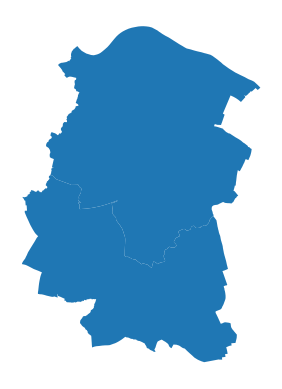

In [24]:
clipping_dataset= gdf[gdf['id'].isin(['90','99'])]
ax=clipping_dataset.plot()
ax.set_axis_off()

The path to the original dataset and the clipping dataset, based on which the original dataset should be clipped, will be defined.

In [25]:
original_dataset = gp.read_file(gdb_path, layer="Biotopwerte_Dresden_2018")

The coordinate system of the datasets is checked. If the coordinate systems do not match, the clipping process will not proceed.

In [26]:
original_dataset.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Denmark - offshore and offshore; Germany - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 46.4, 18.01, 84.42)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [27]:
clipping_dataset.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

If the coordinate systems are not the same, they are transformed to match.

In [28]:
clipping_dataset = clipping_dataset.to_crs('EPSG:25833')

The dataset is then clipped by defining the original dataset and the clipping dataset using the `clip` function in the `geopandas` package.

In [29]:
clipped_dataset = gp.clip(original_dataset, clipping_dataset)

And the result of the clip operation will be printed out.

In [30]:
clipped_dataset.head(3)

,CLC_st1,Biotpkt2018,Shape_Length,Shape_Area,geometry
261,122,5.271487,1765.048621,6984.236836,"POLYGON ((404092.960 5654379.530, 404098.204 5..."
5928,322,18.055116,204.848619,582.329680,"POLYGON ((404867.050 5654106.355, 404862.483 5..."
13027,142,7.000000,481.434416,11886.564349,"POLYGON ((405339.130 5654136.481, 405172.058 5..."


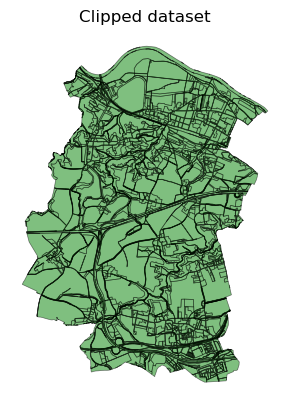

In [31]:
ax = clipped_dataset.plot(color="green", linewidth=0.5, alpha=0.5, edgecolor="black")
ax.set_title("Clipped dataset")
ax.set_axis_off()

The result can be saved in various formats. All you need to do is define the output path and export based on the format you are interested in.

- **Shapefile Format**

In [ ]:
output_shp = OUTPUT / "clipped.shp"
clipped_dataset.to_file(output_shp)

- **GeoPackage Format** 

In [34]:
output_gdb = OUTPUT / "clipped.gpkg"
clipped_dataset.to_file(
    output_gdb,
    layer="clipped_dataset",
    driver="GPKG")

- **CSV Format**

```{admonition} **Geometry as WKT**
:class: caution, dropdown
If the dataset doesn't have a geometry column in Well Known Text format, it should be converted first, which is mentioned in the next steps.
```

To convert the geometry to WKT, first access the geometry column of the GeoDataFrame. Then, use the `apply` function to convert each geometry in the column to a string format.

In [ ]:
clipped_dataset["geometry"] = clipped_dataset["geometry"].apply(lambda geom: geom.wkt)

The output path is defined, and the data is saved as a CSV file. If the index column, which represents unique values for rows, is not needed, the `index` parameter can be set to `False`.

```{admonition} **Parameters for CSV file**
To learn how to customize your CSV data, visit the pandas [DataFrame to CSV page](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html).
```

In [36]:
csv_path = OUTPUT / "clipped_dataset.csv"
clipped_dataset.to_csv(csv_path, index=True)

## Clipping Based on Bounding Box

To show a specific area of the dataset, the data can be clipped to a defined bounding box and then visualized.

For this reason, the required part of the dataset is selected and the bounding box is extracted for this rows.

```{admonition} Bounding Box
:class: attention 
The bounding box extraction explained more in [Creating Maps Chapter](https://stag.training.fdz.ioer.info/notebooks/306_mapping.html#plot-features-within-bounding-box).
```

In [37]:
required_part= original_dataset[80:120].total_bounds

Then the dataset clipped for plotting:

In [38]:
gdf_clipped = gp.clip(original_dataset, required_part)

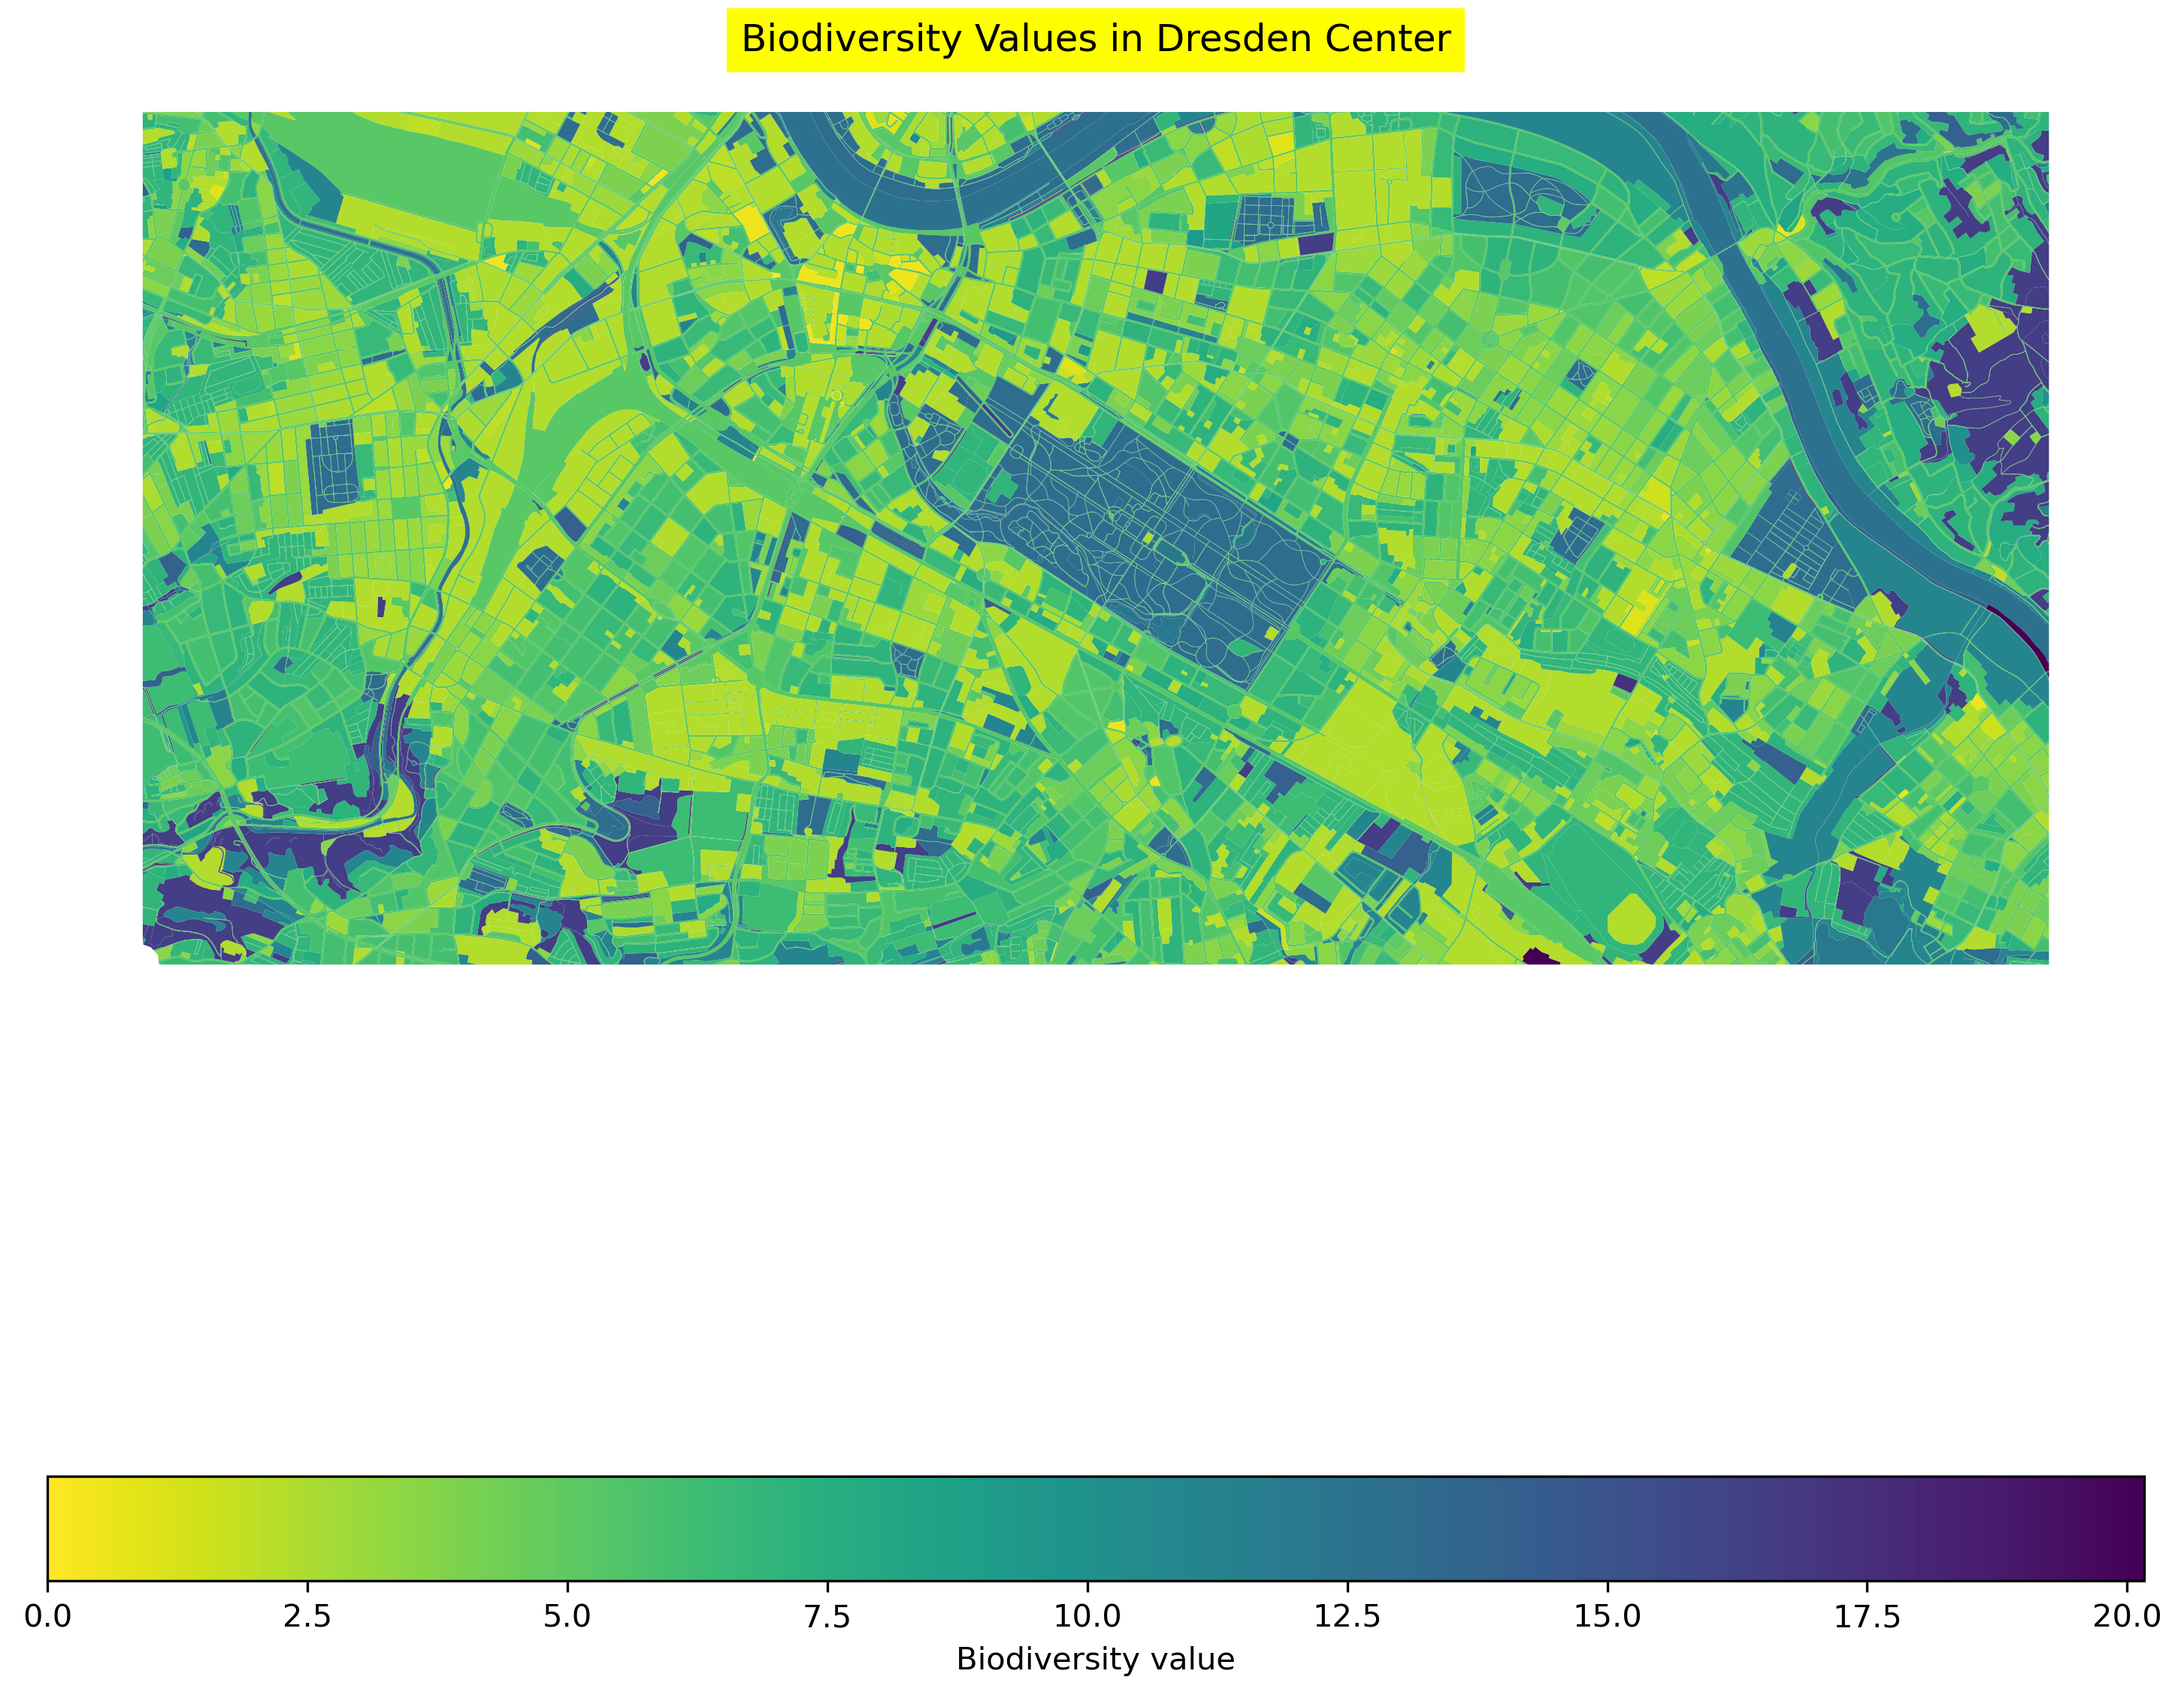

In [39]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(12, 18), dpi=300)

ax = gdf_clipped.plot(
    ax=ax,
    column='Biotpkt2018', 
    cmap='viridis_r',
    legend=True,
    legend_kwds={"label": "Biodiversity value", "orientation": "horizontal"})

ax.set_title('Biodiversity Values in Dresden Center',
             backgroundcolor='yellow',
             color='black')
ax.set_axis_off()